In [1]:
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
prices_df= pd.read_excel('/Desktop/Projects/Existing Portfolio.xlsx')
portfolio_df= pd.read_excel('/Desktop/Projects/Portfolio Structure.xlsx')

In [3]:
portfolio_df

,ETF Name,Underlying Asset,Underlying Index,Portfolio Weight (as of 3/2/2018),Return (Annual),Std. Dev. (Annual)
0,iShares S&P Small Cap 600 UCITS,US Small Cap,S&P Small Cap 600,0.1191,0.0926,0.1557
1,Vanguard S&P 500,US Large Cap,S&P 500,0.2616,0.0832,0.1269
2,SPDR Portfolio Emerging Markets,Emerging Market Equities,S&P Emerging BMI,0.0348,0.0640,0.1429
3,SPDR Bloomberg Barclays T-Bill,US T-Bills,S&P US Treasury Bill,0.0444,0.0048,0.0000
4,ProShares S&P500 Bond,US Corp. Bonds,S&P 500 Bond,0.4711,0.0246,0.0384
5,PowerShares Int’l Corp. Bond Portfolio,Global Corp. Bonds,S&P Int’l Corp. Bond,0.0012,0.0305,0.0874
6,iShares S&P Commodity Indexed Trust,Commodities,S&P GSCI,0.0341,0.0225,0.2033
7,SPDR Gold Trust,Gold,S&P GSCI Gold ER,0.0337,0.0308,0.1366
8,Bitcoin,Bitcoin,Bitcoin,0.0000,0.0000,0.0000


In [4]:
prices_df.head()

,Date,US Small Cap,US Large Cap,Emerging-Market Equities,US T-Bills,US Bonds,Global Bonds,Commodities (GSCI),Gold,Bitcoin
0,2015-03-02,715.06,2117.39,256.56,226.43,398.44,122.63,413.06,703.42,275.67
1,2015-03-03,710.78,2107.78,255.62,226.43,397.83,122.35,417.21,701.21,281.70
2,2015-03-04,706.44,2098.53,253.16,226.43,397.78,121.18,417.37,699.17,273.09
3,2015-03-05,707.24,2101.04,253.18,226.44,398.19,120.93,414.71,696.44,276.18
4,2015-03-06,697.18,2071.26,251.73,226.43,395.25,118.96,411.78,677.99,272.72


In [5]:
# Convert the 'Date' column to a datetime object and set it as the index
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df.set_index('Date', inplace=True)

In [23]:
# Calculate the daily returns
daily_returns = prices_df.pct_change()
daily_returns=daily_returns.iloc[1:len(daily_returns.index),:]
# Calculate the average daily return and daily volatility for each asset
average_daily_returns = daily_returns.mean()*100
daily_volatility = daily_returns.std()
daily_volatility['US T-Bills']=0
# Display the results
print("Average Daily Returns (%):")
print(average_daily_returns)
print("\nDaily Volatility (Standard Deviation, %):")
print(daily_volatility)

Average Daily Returns (%):
US Small Cap                0.039958
US Large Cap                0.034916
Emerging-Market Equities    0.028695
US T-Bills                  0.001917
US Bonds                    0.009917
Global Bonds                0.013452
Commodities (GSCI)          0.017067
Gold                        0.015759
Bitcoin                     0.592187
dtype: float64

Daily Volatility (Standard Deviation, %):
US Small Cap                0.009851
US Large Cap                0.008031
Emerging-Market Equities    0.009046
US T-Bills                  0.000000
US Bonds                    0.002433
Global Bonds                0.005533
Commodities (GSCI)          0.012866
Gold                        0.008647
Bitcoin                     0.045599
dtype: float64


/var/folders/fr/3mbht5jn2hd8ltqs0dfl7myr0000gn/T/ipykernel_87981/2949931550.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_var_cov_matrix = var_cov_matrix.applymap(lambda x: f'{x:.5f}')


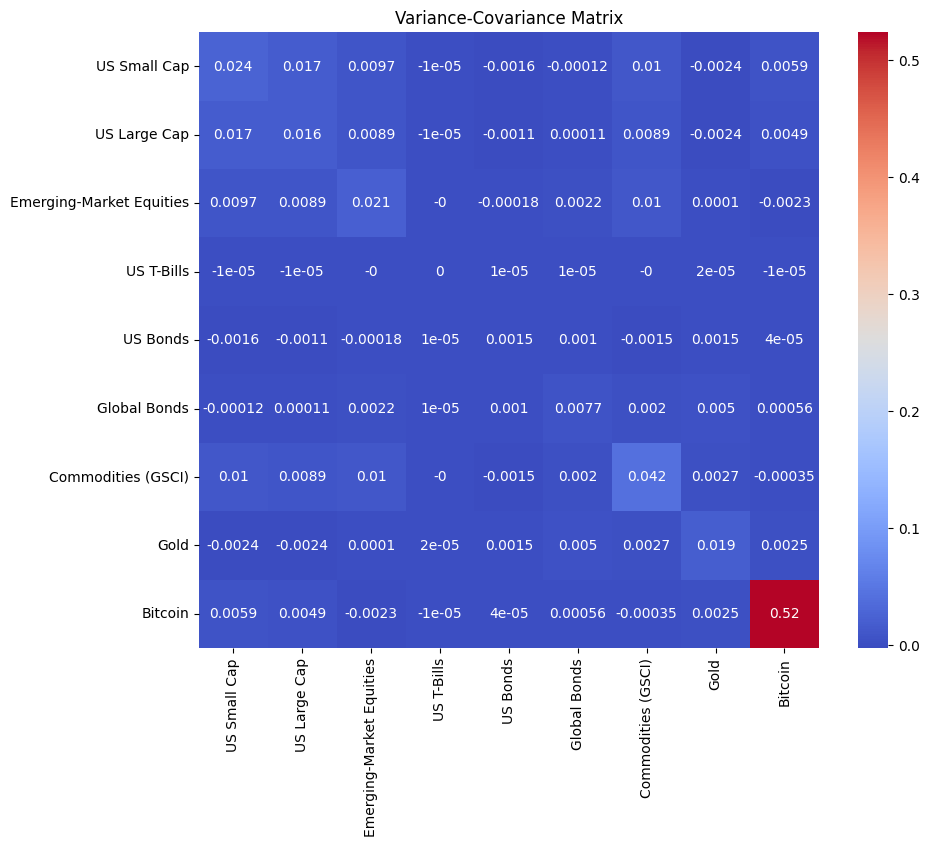

In [7]:
# Compute the variance-covariance matrix
var_cov_matrix = daily_returns.cov()*252
formatted_var_cov_matrix = var_cov_matrix.applymap(lambda x: f'{x:.5f}')
# Display the variance-covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(formatted_var_cov_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Variance-Covariance Matrix')
plt.show()

In [8]:
# Retrieve the portfolio weights for each asset
# The order of weights should correspond to the order of assets in the prices_df
weights = portfolio_df['Portfolio Weight (as of 3/2/2018)'].values
# Calculate the weighted daily returns for the portfolio
weighted_daily_returns = (daily_returns * weights).sum(axis=1)

# Calculate the average daily return and daily volatility for the portfolio
average_daily_return = weighted_daily_returns.mean()
daily_volatility = weighted_daily_returns.std()

# Convert to percentage
average_daily_return_percent = average_daily_return * 100
daily_volatility_percent = daily_volatility * 100

print(f"Average Daily Return of Portfolio: {average_daily_return_percent:.2f}%")
print(f"Daily Volatility (Standard Deviation) of Portfolio: {daily_volatility_percent:.2f}%")

Average Daily Return of Portfolio: 0.02%
Daily Volatility (Standard Deviation) of Portfolio: 0.34%


In [9]:
# Retrieve the annual return rate of the T-Bill from the portfolio_df
rf = portfolio_df.loc[portfolio_df['ETF Name'] == 'SPDR Bloomberg Barclays T-Bill', 'Return (Annual)'].values[0]
annual_portfolio_returns=portfolio_df['Return (Annual)'].values
portfolio_return=sum(weights*annual_portfolio_returns)
portfolio_sd = np.sqrt(np.dot(weights.T, np.dot(var_cov_matrix, weights))) 
# Calculate the Sharpe Ratio
sharpe_ratio = (portfolio_return -rf)/portfolio_sd
sharpe_ratio

0.8105351122993856

In [10]:
# We need to exclude the 'SPDR Bloomberg Barclays T-Bill' as it's not a risky asset
risky_assets_returns = daily_returns.drop(columns=['US T-Bills'])
risky_assets_weights = portfolio_df.loc[portfolio_df['ETF Name'] != 'SPDR Bloomberg Barclays T-Bill', 'Portfolio Weight (as of 3/2/2018)']

# Calculate expected returns and covariance matrix for the risky assets
expected_annual_returns = risky_assets_returns.mean() * 252
covariance_matrix = risky_assets_returns.cov() * 252

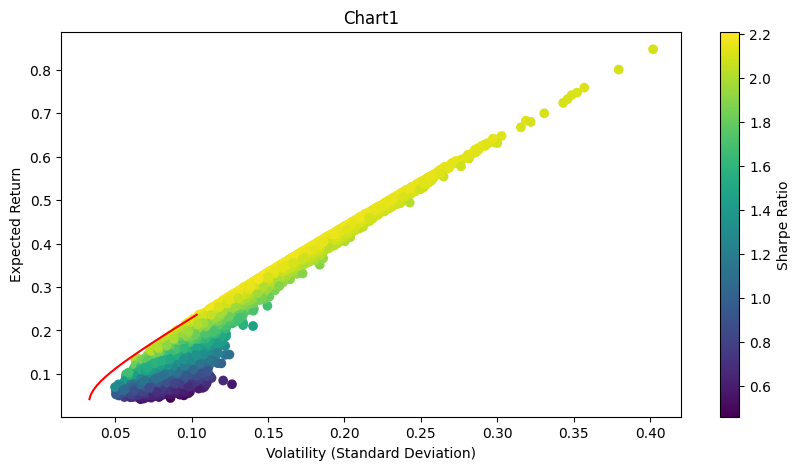

In [11]:
# Number of portfolios to simulate
num_portfolios = 35000

# Arrays to store results
all_weights = np.zeros((num_portfolios, len(risky_assets_returns.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

# Risk-free rate for Sharpe ratio calculation (assumed to be zero for simplicity)
risk_free_rate = rf

# Simulate random portfolio weights:
np.random.seed(42)  # For reproducible results
for i in range(num_portfolios):
    # Create random weight vector and normalize to set sum to 1
    weights = np.random.random(len(risky_assets_returns.columns))
    weights /= np.sum(weights)
    
    # Save weights
    all_weights[i, :] = weights
    
    # Expected return
    ret_arr[i] = np.sum(expected_annual_returns * weights)
    
    # Expected volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    # Sharpe Ratio
    sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]

# Portfolio with the maximum Sharpe Ratio
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe_return = ret_arr[max_sharpe_idx]
max_sharpe_volatility = vol_arr[max_sharpe_idx]

# Efficient frontier: Minimum volatility for a given target return
target_returns = np.linspace(ret_arr.min(), max_sharpe_return, 200)
efficient_portfolios = []
for target_return in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.sum(expected_annual_returns * w) - target_return})
    bounds = tuple((0, 1) for _ in range(len(risky_assets_returns.columns)))
    result = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w))), 
                      all_weights[max_sharpe_idx], method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        efficient_portfolios.append(result['x'])
        
efficient_returns = [np.sum(expected_annual_returns * w) for w in efficient_portfolios]
efficient_risks = [np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w))) for w in efficient_portfolios]

# Plotting the efficient frontier
plt.figure(figsize=(10, 5))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.plot(efficient_risks, efficient_returns, 'r')  # Line plot for the efficient frontier
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Chart1')
plt.show()

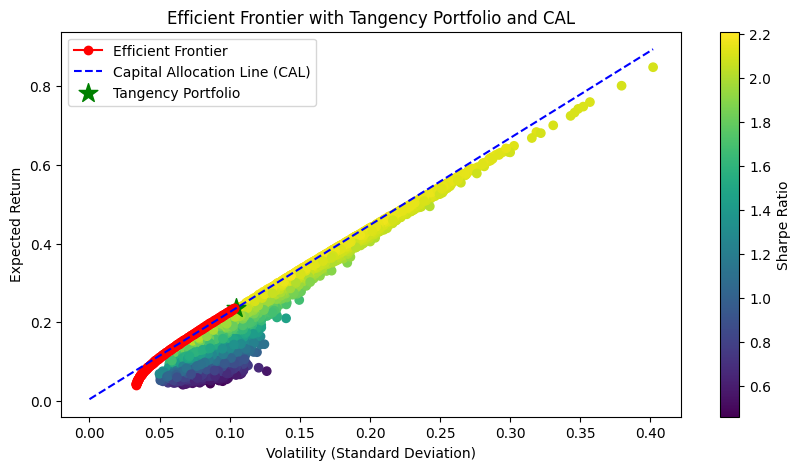

In [12]:
# Find the max Sharpe Ratio portfolio
max_sharpe_idx = sharpe_arr.argmax()
sdp_tangency = vol_arr[max_sharpe_idx]  # Standard deviation (volatility) of the tangency portfolio
r_tangency = ret_arr[max_sharpe_idx]  # Return of the tangency portfolio

# The slope of the CAL (Sharpe Ratio of the tangency portfolio)
cal_slope = (r_tangency - risk_free_rate) / sdp_tangency

# Define the range for the CAL plot, using the max standard deviation from the portfolios as the upper limit
cal_x = np.linspace(0, vol_arr.max(), num=50)
cal_y = risk_free_rate + cal_slope * cal_x

# Plotting the efficient frontier with the CAL
plt.figure(figsize=(10, 5))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.plot(efficient_risks, efficient_returns, 'r-o', label='Efficient Frontier')  # Efficient frontier line
plt.plot(cal_x, cal_y, 'b--', label='Capital Allocation Line (CAL)')  # CAL line
plt.scatter(sdp_tangency, r_tangency, marker='*', color='g', s=200, label='Tangency Portfolio')  # Tangency Portfolio
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Tangency Portfolio and CAL')
plt.legend()
plt.show()

In [13]:
# Find the max Sharpe Ratio from the array
max_sharpe_ratio = sharpe_arr[max_sharpe_idx]

max_sharpe_ratio

2.2108400717305092

The Sharpe Ratio of the tangency portfolio is 2.21 which is higher than the sharpe ratio of the client's current portfolio (0.81), therefore the current portfolio is not optimized.

In [26]:
m=average_daily_returns['Bitcoin'].mean()
sd=daily_returns['Bitcoin'].std()*100
print(f'The average daily return of Bitcoin is:{m:.2f}%')
print(f"The daily volatility of Bitcoin is: {sd:.2f}%")

The average daily return of Bitcoin is:0.59%
The daily volatility of Bitcoin is: 4.56%


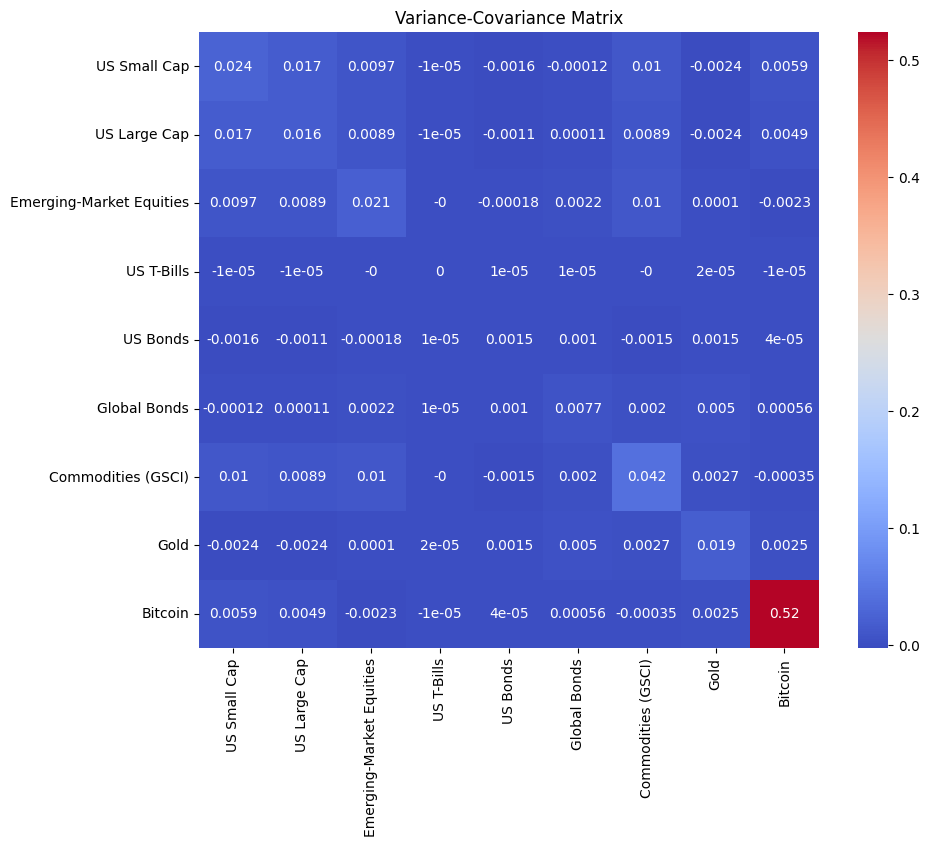

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(formatted_var_cov_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Variance-Covariance Matrix')
plt.show()